In [1]:
#
!nvidia-smi

Fri Jun 13 17:22:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8             10W /   95W |     348MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [3]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
train_data.shape

(10000, 50, 110, 6)

In [6]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [7]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


In [10]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self,
                 input_dim=8,     # 6 (Ego) + 2 (avg x, avg y)
                 hidden_dim=256,
                 output_dim=60 * 2,
                 grid_size=30 
                 ):
        super(LSTM, self).__init__()
        self.R = grid_size  

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        
        B50, T, D = data.x.shape  # B50 = B*50, T=50, D=6
        B = B50 // 50

        all_data = data.x.view(B, 50, 50, 6) 
        ego_traj = all_data[:, 0, :, :] 
        pos_all = all_data[..., :2]

        ego_pos = pos_all[:, 0, :, :]        # [B,50,2]
        others  = pos_all[:, 1:, :, :]       # [B,49,50,2]

        rel = others - ego_pos.unsqueeze(1) 
        dists = torch.norm(rel, dim=-1)

        mask = (dists <= self.R)             # [B,49,50], bool
        mask_expanded = mask.unsqueeze(-1).float()  # [B,49,50,1]
        rel_masked = rel * mask_expanded  
        counts = mask.sum(dim=1).clamp(min=1).unsqueeze(-1)  # [B,50,1]
        avg_rel = rel_masked.sum(dim=1) / counts           # [B,50,2]

        x_in = torch.cat([ego_traj, avg_rel], dim=-1) # [B,50,8]

        lstm_out, _ = self.lstm(x_in)
        final_h = lstm_out[:, -1, :]    # [B,50,hidden_dim]

        out = self.fc(final_h)
        return out.view(-1, 60, 2)


In [11]:
model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75) # You can try different schedulers
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, total_steps=100)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=3)

early_stopping_patience = 100
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75) # You can try different schedulers
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, total_steps=100)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

early_stopping_patience = 100
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

In [13]:
train_mae_list = []
val_mae_list = []
epoch_list = []

for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_mae = 0
    
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
        
        with torch.no_grad():
            pred_un = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y_un = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            train_mae += nn.L1Loss()(pred_un, y_un).item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step(val_loss)
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    epoch_list.append(epoch)

    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   1%|▋                                                                       | 1/100 [00:20<33:01, 20.02s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3210 | val normalized MSE   0.4988, | val MAE   2.7286 | val MSE  24.4420


Epoch:   2%|█▍                                                                      | 2/100 [00:27<20:53, 12.79s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.4466 | val normalized MSE   0.3394, | val MAE   2.2617 | val MSE  16.6319


Epoch:   3%|██▏                                                                     | 3/100 [00:35<16:50, 10.42s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3755 | val normalized MSE   0.3690, | val MAE   2.4438 | val MSE  18.0822


Epoch:   4%|██▉                                                                     | 4/100 [00:42<14:52,  9.29s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3298 | val normalized MSE   0.3387, | val MAE   2.2891 | val MSE  16.5956


Epoch:   5%|███▌                                                                    | 5/100 [00:52<15:03,  9.51s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3212 | val normalized MSE   0.2917, | val MAE   1.9694 | val MSE  14.2922


Epoch:   6%|████▎                                                                   | 6/100 [01:01<14:42,  9.39s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3020 | val normalized MSE   0.2995, | val MAE   2.0685 | val MSE  14.6769


Epoch:   7%|█████                                                                   | 7/100 [01:10<14:09,  9.13s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2915 | val normalized MSE   0.3116, | val MAE   2.0889 | val MSE  15.2700


Epoch:   8%|█████▊                                                                  | 8/100 [01:18<13:20,  8.70s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2865 | val normalized MSE   0.2875, | val MAE   2.0196 | val MSE  14.0876


Epoch:   9%|██████▍                                                                 | 9/100 [01:26<12:48,  8.45s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2763 | val normalized MSE   0.2770, | val MAE   1.9542 | val MSE  13.5717


Epoch:  10%|███████                                                                | 10/100 [01:33<12:20,  8.23s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2661 | val normalized MSE   0.2584, | val MAE   1.9077 | val MSE  12.6609


Epoch:  11%|███████▊                                                               | 11/100 [01:41<11:51,  8.00s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2631 | val normalized MSE   0.2588, | val MAE   1.9196 | val MSE  12.6816


Epoch:  12%|████████▌                                                              | 12/100 [01:48<11:28,  7.82s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2589 | val normalized MSE   0.2343, | val MAE   1.7657 | val MSE  11.4815


Epoch:  13%|█████████▏                                                             | 13/100 [01:56<11:13,  7.74s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2505 | val normalized MSE   0.2245, | val MAE   1.6125 | val MSE  11.0016


Epoch:  14%|█████████▉                                                             | 14/100 [02:03<11:00,  7.68s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2431 | val normalized MSE   0.2302, | val MAE   1.7890 | val MSE  11.2801


Epoch:  15%|██████████▋                                                            | 15/100 [02:11<10:47,  7.62s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2450 | val normalized MSE   0.2276, | val MAE   1.7576 | val MSE  11.1537


Epoch:  16%|███████████▎                                                           | 16/100 [02:19<10:40,  7.63s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2416 | val normalized MSE   0.2203, | val MAE   1.6768 | val MSE  10.7951


Epoch:  17%|████████████                                                           | 17/100 [02:26<10:32,  7.62s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2380 | val normalized MSE   0.2237, | val MAE   1.7072 | val MSE  10.9604


Epoch:  18%|████████████▊                                                          | 18/100 [02:34<10:23,  7.61s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2303 | val normalized MSE   0.2185, | val MAE   1.6622 | val MSE  10.7066


Epoch:  19%|█████████████▍                                                         | 19/100 [02:41<10:13,  7.58s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2305 | val normalized MSE   0.2285, | val MAE   1.7210 | val MSE  11.1979


Epoch:  20%|██████████████▏                                                        | 20/100 [02:49<10:04,  7.56s/epoch]

Epoch 019 | Learning rate 0.001000 | train normalized MSE   0.2256 | val normalized MSE   0.2275, | val MAE   1.7777 | val MSE  11.1464


Epoch:  21%|██████████████▉                                                        | 21/100 [02:57<10:01,  7.62s/epoch]

Epoch 020 | Learning rate 0.001000 | train normalized MSE   0.2220 | val normalized MSE   0.2154, | val MAE   1.6947 | val MSE  10.5533


Epoch:  22%|███████████████▌                                                       | 22/100 [03:04<09:51,  7.58s/epoch]

Epoch 021 | Learning rate 0.001000 | train normalized MSE   0.2280 | val normalized MSE   0.2451, | val MAE   1.9008 | val MSE  12.0106


Epoch:  23%|████████████████▎                                                      | 23/100 [03:11<09:41,  7.55s/epoch]

Epoch 022 | Learning rate 0.001000 | train normalized MSE   0.2218 | val normalized MSE   0.2081, | val MAE   1.6811 | val MSE  10.1955


Epoch:  24%|█████████████████                                                      | 24/100 [03:19<09:34,  7.56s/epoch]

Epoch 023 | Learning rate 0.001000 | train normalized MSE   0.2246 | val normalized MSE   0.2081, | val MAE   1.6080 | val MSE  10.1986


Epoch:  25%|█████████████████▊                                                     | 25/100 [03:27<09:24,  7.52s/epoch]

Epoch 024 | Learning rate 0.001000 | train normalized MSE   0.2159 | val normalized MSE   0.2160, | val MAE   1.7304 | val MSE  10.5847


Epoch:  26%|██████████████████▍                                                    | 26/100 [03:34<09:19,  7.56s/epoch]

Epoch 025 | Learning rate 0.001000 | train normalized MSE   0.2158 | val normalized MSE   0.2024, | val MAE   1.6319 | val MSE   9.9169


Epoch:  27%|███████████████████▏                                                   | 27/100 [03:42<09:12,  7.57s/epoch]

Epoch 026 | Learning rate 0.001000 | train normalized MSE   0.2139 | val normalized MSE   0.1919, | val MAE   1.5717 | val MSE   9.4032


Epoch:  28%|███████████████████▉                                                   | 28/100 [03:49<09:07,  7.61s/epoch]

Epoch 027 | Learning rate 0.001000 | train normalized MSE   0.2130 | val normalized MSE   0.1994, | val MAE   1.5827 | val MSE   9.7720


Epoch:  29%|████████████████████▌                                                  | 29/100 [03:57<09:00,  7.61s/epoch]

Epoch 028 | Learning rate 0.001000 | train normalized MSE   0.2105 | val normalized MSE   0.1960, | val MAE   1.5783 | val MSE   9.6023


Epoch:  30%|█████████████████████▎                                                 | 30/100 [04:05<08:53,  7.62s/epoch]

Epoch 029 | Learning rate 0.001000 | train normalized MSE   0.2114 | val normalized MSE   0.2018, | val MAE   1.6128 | val MSE   9.8875


Epoch:  31%|██████████████████████                                                 | 31/100 [04:12<08:43,  7.59s/epoch]

Epoch 030 | Learning rate 0.000500 | train normalized MSE   0.2094 | val normalized MSE   0.2048, | val MAE   1.6342 | val MSE  10.0355


Epoch:  32%|██████████████████████▋                                                | 32/100 [04:20<08:37,  7.61s/epoch]

Epoch 031 | Learning rate 0.000500 | train normalized MSE   0.1933 | val normalized MSE   0.1818, | val MAE   1.4515 | val MSE   8.9077


Epoch:  33%|███████████████████████▍                                               | 33/100 [04:28<08:33,  7.67s/epoch]

Epoch 032 | Learning rate 0.000500 | train normalized MSE   0.1891 | val normalized MSE   0.1841, | val MAE   1.4432 | val MSE   9.0217


Epoch:  34%|████████████████████████▏                                              | 34/100 [04:35<08:25,  7.66s/epoch]

Epoch 033 | Learning rate 0.000500 | train normalized MSE   0.1891 | val normalized MSE   0.1914, | val MAE   1.5174 | val MSE   9.3786


Epoch:  35%|████████████████████████▊                                              | 35/100 [04:43<08:20,  7.71s/epoch]

Epoch 034 | Learning rate 0.000500 | train normalized MSE   0.1891 | val normalized MSE   0.1830, | val MAE   1.4657 | val MSE   8.9678


Epoch:  36%|█████████████████████████▌                                             | 36/100 [04:51<08:10,  7.66s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1886 | val normalized MSE   0.1881, | val MAE   1.5145 | val MSE   9.2182


Epoch:  37%|██████████████████████████▎                                            | 37/100 [04:58<08:01,  7.64s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1806 | val normalized MSE   0.1751, | val MAE   1.4061 | val MSE   8.5793


Epoch:  38%|██████████████████████████▉                                            | 38/100 [05:06<07:51,  7.60s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1770 | val normalized MSE   0.1792, | val MAE   1.4212 | val MSE   8.7825


Epoch:  39%|███████████████████████████▋                                           | 39/100 [05:13<07:44,  7.61s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1784 | val normalized MSE   0.1779, | val MAE   1.4066 | val MSE   8.7157


Epoch:  40%|████████████████████████████▍                                          | 40/100 [05:21<07:42,  7.71s/epoch]

Epoch 039 | Learning rate 0.000250 | train normalized MSE   0.1774 | val normalized MSE   0.1737, | val MAE   1.3947 | val MSE   8.5112


Epoch:  41%|█████████████████████████████                                          | 41/100 [05:29<07:39,  7.79s/epoch]

Epoch 040 | Learning rate 0.000250 | train normalized MSE   0.1776 | val normalized MSE   0.1753, | val MAE   1.3847 | val MSE   8.5903


Epoch:  42%|█████████████████████████████▊                                         | 42/100 [05:37<07:34,  7.84s/epoch]

Epoch 041 | Learning rate 0.000250 | train normalized MSE   0.1765 | val normalized MSE   0.1743, | val MAE   1.3933 | val MSE   8.5387


Epoch:  43%|██████████████████████████████▌                                        | 43/100 [05:45<07:27,  7.86s/epoch]

Epoch 042 | Learning rate 0.000250 | train normalized MSE   0.1765 | val normalized MSE   0.1749, | val MAE   1.4119 | val MSE   8.5685


Epoch:  44%|███████████████████████████████▏                                       | 44/100 [05:53<07:22,  7.90s/epoch]

Epoch 043 | Learning rate 0.000125 | train normalized MSE   0.1754 | val normalized MSE   0.1767, | val MAE   1.4379 | val MSE   8.6575


Epoch:  45%|███████████████████████████████▉                                       | 45/100 [06:01<07:15,  7.91s/epoch]

Epoch 044 | Learning rate 0.000125 | train normalized MSE   0.1697 | val normalized MSE   0.1725, | val MAE   1.3876 | val MSE   8.4526


Epoch:  46%|████████████████████████████████▋                                      | 46/100 [06:09<07:06,  7.89s/epoch]

Epoch 045 | Learning rate 0.000125 | train normalized MSE   0.1699 | val normalized MSE   0.1718, | val MAE   1.3600 | val MSE   8.4184


Epoch:  47%|█████████████████████████████████▎                                     | 47/100 [06:17<06:53,  7.81s/epoch]

Epoch 046 | Learning rate 0.000125 | train normalized MSE   0.1691 | val normalized MSE   0.1697, | val MAE   1.3759 | val MSE   8.3164


Epoch:  48%|██████████████████████████████████                                     | 48/100 [06:24<06:42,  7.73s/epoch]

Epoch 047 | Learning rate 0.000125 | train normalized MSE   0.1682 | val normalized MSE   0.1680, | val MAE   1.3422 | val MSE   8.2327


Epoch:  49%|██████████████████████████████████▊                                    | 49/100 [06:32<06:34,  7.74s/epoch]

Epoch 048 | Learning rate 0.000125 | train normalized MSE   0.1689 | val normalized MSE   0.1700, | val MAE   1.3767 | val MSE   8.3323


Epoch:  50%|███████████████████████████████████▌                                   | 50/100 [06:40<06:26,  7.73s/epoch]

Epoch 049 | Learning rate 0.000125 | train normalized MSE   0.1670 | val normalized MSE   0.1697, | val MAE   1.3716 | val MSE   8.3135


Epoch:  51%|████████████████████████████████████▏                                  | 51/100 [06:47<06:19,  7.74s/epoch]

Epoch 050 | Learning rate 0.000125 | train normalized MSE   0.1668 | val normalized MSE   0.1694, | val MAE   1.3616 | val MSE   8.3014


Epoch:  52%|████████████████████████████████████▉                                  | 52/100 [06:55<06:09,  7.69s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1669 | val normalized MSE   0.1718, | val MAE   1.3653 | val MSE   8.4181


Epoch:  53%|█████████████████████████████████████▋                                 | 53/100 [07:03<06:00,  7.67s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1644 | val normalized MSE   0.1684, | val MAE   1.3422 | val MSE   8.2519


Epoch:  54%|██████████████████████████████████████▎                                | 54/100 [07:10<05:53,  7.69s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1646 | val normalized MSE   0.1694, | val MAE   1.3636 | val MSE   8.2991


Epoch:  55%|███████████████████████████████████████                                | 55/100 [07:18<05:48,  7.74s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1640 | val normalized MSE   0.1671, | val MAE   1.3278 | val MSE   8.1863


Epoch:  56%|███████████████████████████████████████▊                               | 56/100 [07:26<05:41,  7.75s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1631 | val normalized MSE   0.1668, | val MAE   1.3316 | val MSE   8.1711


Epoch:  57%|████████████████████████████████████████▍                              | 57/100 [07:34<05:33,  7.77s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1640 | val normalized MSE   0.1675, | val MAE   1.3515 | val MSE   8.2095


Epoch:  58%|█████████████████████████████████████████▏                             | 58/100 [07:41<05:24,  7.71s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1627 | val normalized MSE   0.1673, | val MAE   1.3305 | val MSE   8.1984


Epoch:  59%|█████████████████████████████████████████▉                             | 59/100 [07:49<05:14,  7.68s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1645 | val normalized MSE   0.1679, | val MAE   1.3584 | val MSE   8.2251


Epoch:  60%|██████████████████████████████████████████▌                            | 60/100 [07:57<05:06,  7.66s/epoch]

Epoch 059 | Learning rate 0.000063 | train normalized MSE   0.1626 | val normalized MSE   0.1657, | val MAE   1.3408 | val MSE   8.1196


Epoch:  61%|███████████████████████████████████████████▎                           | 61/100 [08:04<04:57,  7.63s/epoch]

Epoch 060 | Learning rate 0.000063 | train normalized MSE   0.1625 | val normalized MSE   0.1668, | val MAE   1.3254 | val MSE   8.1750


Epoch:  62%|████████████████████████████████████████████                           | 62/100 [08:12<04:50,  7.65s/epoch]

Epoch 061 | Learning rate 0.000063 | train normalized MSE   0.1626 | val normalized MSE   0.1686, | val MAE   1.3539 | val MSE   8.2608


Epoch:  63%|████████████████████████████████████████████▋                          | 63/100 [08:19<04:42,  7.65s/epoch]

Epoch 062 | Learning rate 0.000063 | train normalized MSE   0.1637 | val normalized MSE   0.1662, | val MAE   1.3378 | val MSE   8.1446


Epoch:  64%|█████████████████████████████████████████████▍                         | 64/100 [08:27<04:35,  7.66s/epoch]

Epoch 063 | Learning rate 0.000031 | train normalized MSE   0.1617 | val normalized MSE   0.1677, | val MAE   1.3337 | val MSE   8.2152


Epoch:  65%|██████████████████████████████████████████████▏                        | 65/100 [08:35<04:28,  7.67s/epoch]

Epoch 064 | Learning rate 0.000031 | train normalized MSE   0.1605 | val normalized MSE   0.1659, | val MAE   1.3119 | val MSE   8.1308


Epoch:  66%|██████████████████████████████████████████████▊                        | 66/100 [08:43<04:20,  7.67s/epoch]

Epoch 065 | Learning rate 0.000031 | train normalized MSE   0.1596 | val normalized MSE   0.1654, | val MAE   1.3170 | val MSE   8.1054


Epoch:  67%|███████████████████████████████████████████████▌                       | 67/100 [08:50<04:13,  7.68s/epoch]

Epoch 066 | Learning rate 0.000031 | train normalized MSE   0.1598 | val normalized MSE   0.1661, | val MAE   1.3187 | val MSE   8.1365


Epoch:  68%|████████████████████████████████████████████████▎                      | 68/100 [08:58<04:04,  7.66s/epoch]

Epoch 067 | Learning rate 0.000031 | train normalized MSE   0.1599 | val normalized MSE   0.1670, | val MAE   1.3331 | val MSE   8.1846


Epoch:  69%|████████████████████████████████████████████████▉                      | 69/100 [09:06<03:57,  7.67s/epoch]

Epoch 068 | Learning rate 0.000031 | train normalized MSE   0.1595 | val normalized MSE   0.1662, | val MAE   1.3233 | val MSE   8.1414


Epoch:  70%|█████████████████████████████████████████████████▋                     | 70/100 [09:13<03:49,  7.66s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1601 | val normalized MSE   0.1656, | val MAE   1.3245 | val MSE   8.1162


Epoch:  71%|██████████████████████████████████████████████████▍                    | 71/100 [09:21<03:42,  7.67s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1580 | val normalized MSE   0.1653, | val MAE   1.3173 | val MSE   8.1000


Epoch:  72%|███████████████████████████████████████████████████                    | 72/100 [09:29<03:34,  7.66s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1583 | val normalized MSE   0.1655, | val MAE   1.3212 | val MSE   8.1105


Epoch:  73%|███████████████████████████████████████████████████▊                   | 73/100 [09:36<03:27,  7.68s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1590 | val normalized MSE   0.1656, | val MAE   1.3163 | val MSE   8.1134


Epoch:  74%|████████████████████████████████████████████████████▌                  | 74/100 [09:44<03:20,  7.72s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1584 | val normalized MSE   0.1652, | val MAE   1.3168 | val MSE   8.0940


Epoch:  75%|█████████████████████████████████████████████████████▎                 | 75/100 [09:52<03:13,  7.74s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1574 | val normalized MSE   0.1658, | val MAE   1.3163 | val MSE   8.1226


Epoch:  76%|█████████████████████████████████████████████████████▉                 | 76/100 [10:00<03:07,  7.81s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1565 | val normalized MSE   0.1662, | val MAE   1.3238 | val MSE   8.1418


Epoch:  77%|██████████████████████████████████████████████████████▋                | 77/100 [10:07<02:58,  7.77s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1577 | val normalized MSE   0.1666, | val MAE   1.3244 | val MSE   8.1629


Epoch:  78%|███████████████████████████████████████████████████████▍               | 78/100 [10:15<02:51,  7.78s/epoch]

Epoch 077 | Learning rate 0.000008 | train normalized MSE   0.1582 | val normalized MSE   0.1657, | val MAE   1.3226 | val MSE   8.1193


Epoch:  79%|████████████████████████████████████████████████████████               | 79/100 [10:23<02:42,  7.75s/epoch]

Epoch 078 | Learning rate 0.000008 | train normalized MSE   0.1580 | val normalized MSE   0.1651, | val MAE   1.3205 | val MSE   8.0911


Epoch:  80%|████████████████████████████████████████████████████████▊              | 80/100 [10:31<02:35,  7.75s/epoch]

Epoch 079 | Learning rate 0.000008 | train normalized MSE   0.1576 | val normalized MSE   0.1652, | val MAE   1.3172 | val MSE   8.0965


Epoch:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [10:38<02:27,  7.76s/epoch]

Epoch 080 | Learning rate 0.000008 | train normalized MSE   0.1576 | val normalized MSE   0.1659, | val MAE   1.3208 | val MSE   8.1286


Epoch:  82%|██████████████████████████████████████████████████████████▏            | 82/100 [10:46<02:20,  7.78s/epoch]

Epoch 081 | Learning rate 0.000008 | train normalized MSE   0.1575 | val normalized MSE   0.1655, | val MAE   1.3173 | val MSE   8.1083


Epoch:  83%|██████████████████████████████████████████████████████████▉            | 83/100 [10:54<02:12,  7.77s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1581 | val normalized MSE   0.1652, | val MAE   1.3175 | val MSE   8.0957


Epoch:  84%|███████████████████████████████████████████████████████████▋           | 84/100 [11:02<02:04,  7.81s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1571 | val normalized MSE   0.1651, | val MAE   1.3154 | val MSE   8.0921


Epoch:  85%|████████████████████████████████████████████████████████████▎          | 85/100 [11:10<01:56,  7.77s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1568 | val normalized MSE   0.1652, | val MAE   1.3161 | val MSE   8.0944


Epoch:  86%|█████████████████████████████████████████████████████████████          | 86/100 [11:18<01:49,  7.81s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1573 | val normalized MSE   0.1651, | val MAE   1.3153 | val MSE   8.0915


Epoch:  87%|█████████████████████████████████████████████████████████████▊         | 87/100 [11:26<01:42,  7.86s/epoch]

Epoch 086 | Learning rate 0.000002 | train normalized MSE   0.1568 | val normalized MSE   0.1653, | val MAE   1.3163 | val MSE   8.1009


Epoch:  88%|██████████████████████████████████████████████████████████████▍        | 88/100 [11:33<01:34,  7.88s/epoch]

Epoch 087 | Learning rate 0.000002 | train normalized MSE   0.1583 | val normalized MSE   0.1653, | val MAE   1.3147 | val MSE   8.1000


Epoch:  89%|███████████████████████████████████████████████████████████████▏       | 89/100 [11:41<01:25,  7.81s/epoch]

Epoch 088 | Learning rate 0.000002 | train normalized MSE   0.1566 | val normalized MSE   0.1652, | val MAE   1.3142 | val MSE   8.0952


Epoch:  90%|███████████████████████████████████████████████████████████████▉       | 90/100 [11:49<01:18,  7.83s/epoch]

Epoch 089 | Learning rate 0.000002 | train normalized MSE   0.1578 | val normalized MSE   0.1653, | val MAE   1.3157 | val MSE   8.1006


Epoch:  91%|████████████████████████████████████████████████████████████████▌      | 91/100 [11:57<01:10,  7.81s/epoch]

Epoch 090 | Learning rate 0.000001 | train normalized MSE   0.1585 | val normalized MSE   0.1654, | val MAE   1.3158 | val MSE   8.1029


Epoch:  92%|█████████████████████████████████████████████████████████████████▎     | 92/100 [12:04<01:01,  7.72s/epoch]

Epoch 091 | Learning rate 0.000001 | train normalized MSE   0.1567 | val normalized MSE   0.1654, | val MAE   1.3160 | val MSE   8.1051


Epoch:  93%|██████████████████████████████████████████████████████████████████     | 93/100 [12:12<00:53,  7.65s/epoch]

Epoch 092 | Learning rate 0.000001 | train normalized MSE   0.1575 | val normalized MSE   0.1654, | val MAE   1.3164 | val MSE   8.1041


Epoch:  94%|██████████████████████████████████████████████████████████████████▋    | 94/100 [12:19<00:45,  7.62s/epoch]

Epoch 093 | Learning rate 0.000001 | train normalized MSE   0.1562 | val normalized MSE   0.1654, | val MAE   1.3162 | val MSE   8.1040


Epoch:  95%|███████████████████████████████████████████████████████████████████▍   | 95/100 [12:27<00:38,  7.66s/epoch]

Epoch 094 | Learning rate 0.000000 | train normalized MSE   0.1562 | val normalized MSE   0.1654, | val MAE   1.3159 | val MSE   8.1025


Epoch:  96%|████████████████████████████████████████████████████████████████████▏  | 96/100 [12:35<00:30,  7.65s/epoch]

Epoch 095 | Learning rate 0.000000 | train normalized MSE   0.1578 | val normalized MSE   0.1654, | val MAE   1.3160 | val MSE   8.1036


Epoch:  97%|████████████████████████████████████████████████████████████████████▊  | 97/100 [12:42<00:22,  7.65s/epoch]

Epoch 096 | Learning rate 0.000000 | train normalized MSE   0.1576 | val normalized MSE   0.1654, | val MAE   1.3160 | val MSE   8.1032


Epoch:  98%|█████████████████████████████████████████████████████████████████████▌ | 98/100 [12:50<00:15,  7.73s/epoch]

Epoch 097 | Learning rate 0.000000 | train normalized MSE   0.1575 | val normalized MSE   0.1653, | val MAE   1.3158 | val MSE   8.1018


Epoch:  99%|██████████████████████████████████████████████████████████████████████▎| 99/100 [12:58<00:07,  7.73s/epoch]

Epoch 098 | Learning rate 0.000000 | train normalized MSE   0.1579 | val normalized MSE   0.1653, | val MAE   1.3159 | val MSE   8.1009


Epoch: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [13:06<00:00,  7.86s/epoch]

Epoch 099 | Learning rate 0.000000 | train normalized MSE   0.1568 | val normalized MSE   0.1653, | val MAE   1.3158 | val MSE   8.1009


In [14]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

C:\Users\Xuanhao Zhu\AppData\Local\Temp\ipykernel_13928\1958007710.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_model.pt")


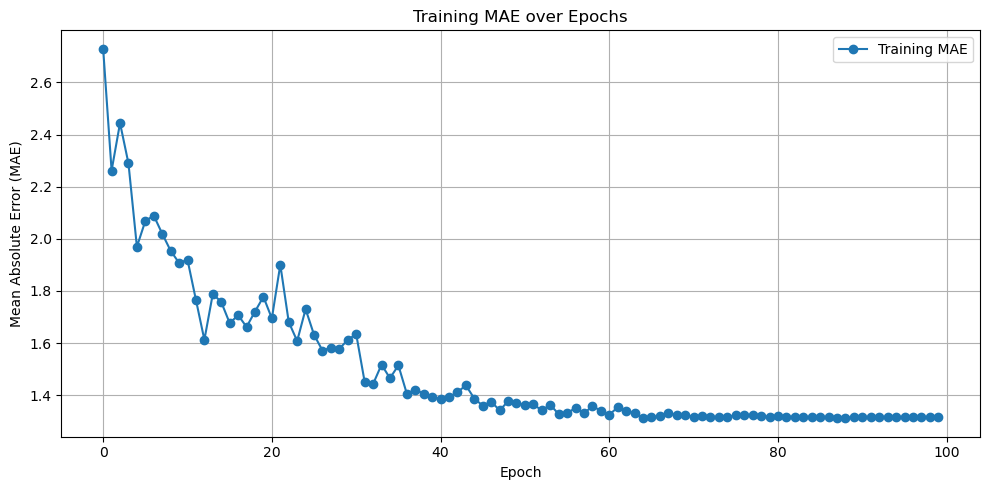

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epoch_list, val_mae_list, marker='o', label='Training MAE')
plt.title('Training MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

C:\Users\Xuanhao Zhu\AppData\Local\Temp\ipykernel_13928\296312515.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


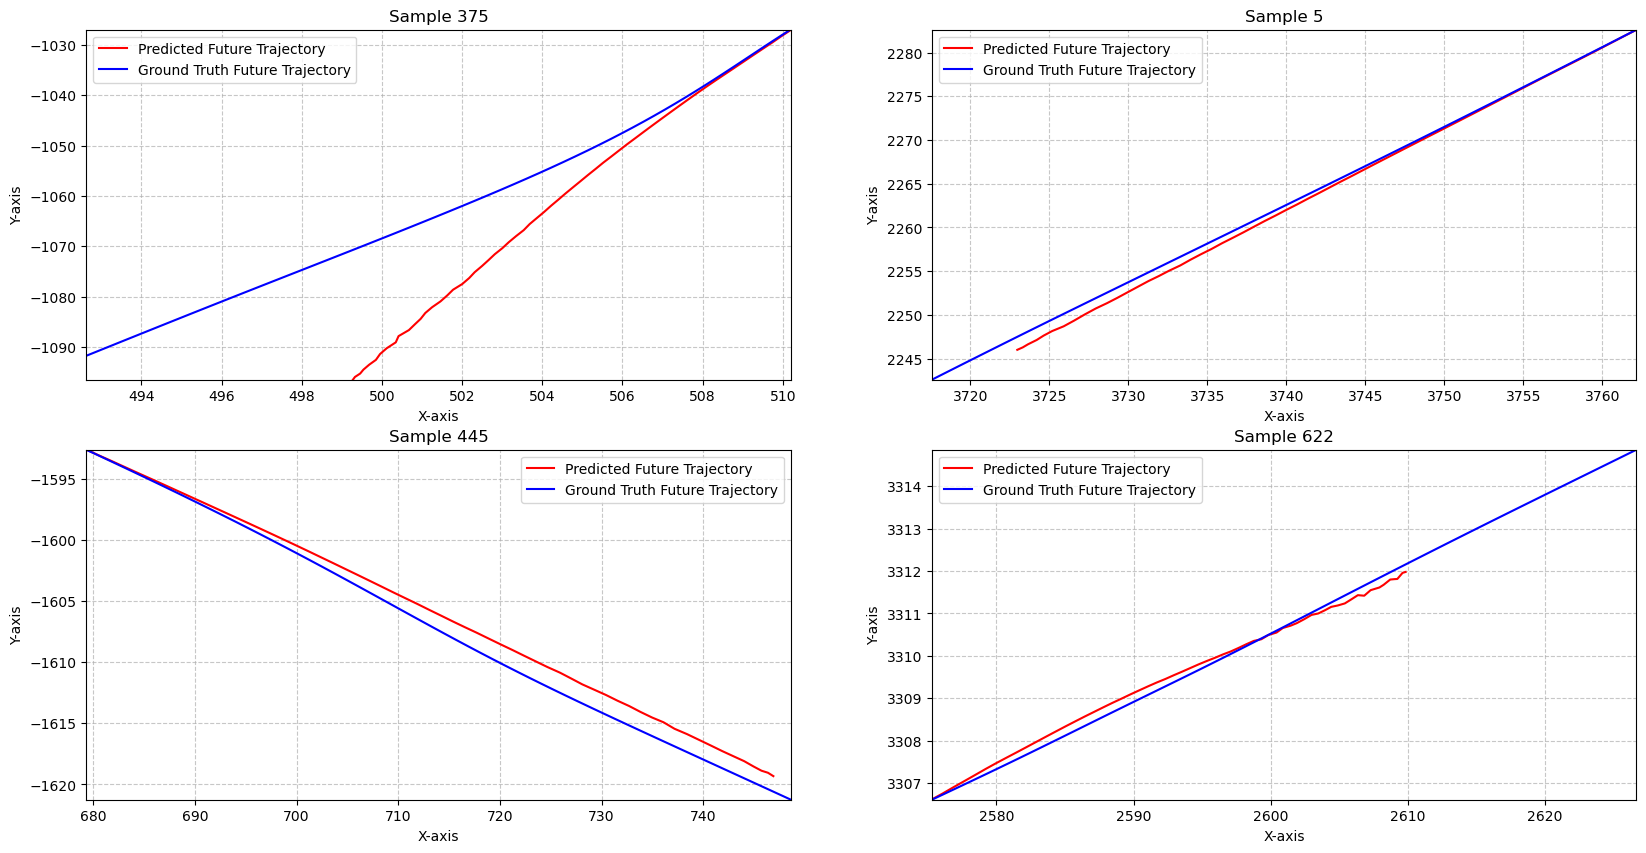

In [18]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()